In [3]:
import os
import json
import numpy as np
import pandas as pd

# Section1: Data Importation

## Step1 Get the basic paper review information

In [4]:
def get_paper_info(conference_name, paper_type):
    reviews_dir = f"PeerRead/data/{conference_name}/{paper_type}/reviews"
    papers = []
    for filename in os.listdir(reviews_dir):
        file_path = os.path.join(reviews_dir, filename)
        if filename.endswith('.json'):
            with open(file_path, 'r') as f:
                data = json.load(f)
                title = data['title']
                for review in data['reviews']:
                    paper = {
                        'title': title,
                        "IMPACT": review.get("IMPACT", np.nan),
                        "SUBSTANCE": review.get("SUBSTANCE", np.nan),
                        "APPROPRIATENESS": review.get("APPROPRIATENESS", np.nan),
                        "MEANINGFUL_COMPARISON": review.get("MEANINGFUL_COMPARISON", np.nan),
                        "PRESENTATION_FORMAT": review.get("PRESENTATION_FORMAT", np.nan),
                        "comments": review.get("comments", np.nan),
                        "SOUNDNESS_CORRECTNESS": review.get("SOUNDNESS_CORRECTNESS", np.nan),
                        "ORIGINALITY": review.get("ORIGINALITY", np.nan),
                        "RECOMMENDATION": review.get("RECOMMENDATION", np.nan),
                        "CLARITY": review.get("CLARITY", np.nan),
                        "REVIEWER_CONFIDENCE": review.get("REVIEWER_CONFIDENCE", np.nan)
                    }
                    papers.append(paper)
    return papers   

In [5]:
conference_names = ['conll_2016', 'acl_2017']
paper_types = ['train', 'dev', 'test']
papers_conll_2016 = []
papers_iclr_2017 = []
for conference_name in conference_names:
    for paper_type in paper_types:
        try:
            papers = get_paper_info(conference_name, paper_type)
        except:
            print(f"Error processing {conference_name}/{paper_type}")
        papers = get_paper_info(conference_name, paper_type)
 
        if conference_name == 'conll_2016':
            papers_conll_2016 += papers
        else:
            papers_iclr_2017 += papers  

In [6]:
conll_2016_df = pd.DataFrame(papers_conll_2016)
acl_2017_df = pd.DataFrame(papers_iclr_2017)
conll_2016_df.to_pickle('data/conll_2016.pkl')
acl_2017_df.to_pickle('data/acl_2017.pkl')

In [7]:
conll_2016_title = list(conll_2016_df['title'])
acl_2017_title = list(acl_2017_df['title'])

In [9]:

all_title = set(conll_2016_title).union(set(acl_2017_title))
with open('data/all_title.txt', 'w') as f:
    for title in all_title:
        f.write("%s\n" % title)
# After this step, we use the Chatgpt for us to collect the citations for each of the papers in the list.

## Step2 Get the acceptance and citation information using GPT and google scholar

In [10]:
import json
with open('data/citation.json', 'r') as file:
    data_citation = json.load(file)

In [11]:
data_citation["A Comparison of Robust Parsing Methods for HPSG"]

{'is_accepted': True, 'citation_num': 230}

In [12]:
df_citation = pd.DataFrame.from_dict(data_citation, orient='index')
df_citation.reset_index(inplace=True)
df_citation.rename(columns={'index': 'paper_title'}, inplace=True)
df_citation.head(5)

# Nan values in the dataframe indicate that the paper was not found in Google Scholar.

,paper_title,is_accepted,citation_num
0,CANE: Context-Aware Network Embedding for Rela...,True,158.0
1,Weakly Supervised Cross-Lingual Named Entity R...,True,135.0
2,Discovering Correspondences between Multiple L...,False,NaN
3,Learning a Neural Semantic Parser from User Fe...,True,89.0
4,Morphological Inflection Generation with Hard ...,True,183.0


In [13]:
valid_title = list(df_citation[df_citation['is_accepted'] == True]['paper_title'])

In [14]:
conll_accepted_df = conll_2016_df[conll_2016_df['title'].isin(valid_title)].reset_index(drop=True)
conll_accepted_df['citation_count'] = conll_accepted_df['title'].apply(
    lambda x: data_citation[x]['citation_num'] 
)
conll_accepted_df['source'] = 'conll_2016' 
conll_accepted_df.to_pickle('data/conll_accepted.pkl')

In [15]:
acl_accepted = acl_2017_df[acl_2017_df['title'].isin(valid_title)].reset_index(drop=True)
acl_accepted['citation_count'] = acl_accepted['title'].apply(
    lambda x: data_citation[x]['citation_num'] 
)
acl_accepted['source'] = 'acl_2017'
acl_accepted.to_pickle('data/acl_accepted.pkl')

### union the two sources

In [16]:
combined_df = pd.concat([conll_accepted_df, acl_accepted], ignore_index=True)

In [17]:
combined_df.to_pickle('data/combined_accepted.pkl')

# Section2: Initial Exploration

In [18]:
accepted_paper = pd.read_pickle('data/combined_accepted.pkl')

In [19]:
accepted_paper.head(5)

,title,IMPACT,SUBSTANCE,APPROPRIATENESS,MEANINGFUL_COMPARISON,PRESENTATION_FORMAT,comments,SOUNDNESS_CORRECTNESS,ORIGINALITY,RECOMMENDATION,CLARITY,REVIEWER_CONFIDENCE,citation_count,source
0,Redefining part-of-speech classes with distrib...,2,1,3,3,Poster,The aim of this paper is to show that distribu...,4,2,2,4,4,80,conll_2016
1,Redefining part-of-speech classes with distrib...,2,4,5,1,Poster,## General comments:\nThis paper presents an e...,4,2,2,4,5,80,conll_2016
2,Massively Multilingual Word Embeddings,3,3,4,3,Poster,This paper describes four methods of obtaining...,4,3,3,4,4,130,conll_2016
3,Massively Multilingual Word Embeddings,4,5,4,5,Poster,This paper proposes two dictionary-based metho...,5,3,3,5,4,130,conll_2016
4,Semi-supervised Convolutional Networks for Tra...,4,4,5,4,Poster,The paper describes an MT training data select...,4,3,4,3,4,70,conll_2016


In [20]:
accepted_paper.columns

Index(['title', 'IMPACT', 'SUBSTANCE', 'APPROPRIATENESS',
       'MEANINGFUL_COMPARISON', 'PRESENTATION_FORMAT', 'comments',
       'SOUNDNESS_CORRECTNESS', 'ORIGINALITY', 'RECOMMENDATION', 'CLARITY',
       'REVIEWER_CONFIDENCE', 'citation_count', 'source'],
      dtype='object')

### 📊 Paper Review Index Breakdown

| Index | What It Means | Why It Matters |
|-------|----------------|----------------|
| `title` | Title of the paper | Useful for identifying the paper, but doesn't influence acceptance or citations. |
| `IMPACT` | Potential impact of the work on the field | **Important for both acceptance & citations**. High-impact papers are more likely to be accepted and cited. |
| `SUBSTANCE` | Depth and completeness of the contribution | **Highly important** for acceptance. Reviewers value comprehensive and substantial work. |
| `APPROPRIATENESS` | Suitability for the conference or venue | **Critical for acceptance**. Even great work can be rejected if off-topic. |
| `MEANINGFUL_COMPARISON` | Quality of experiments and baselines | **Relevant to acceptance**. Good comparisons increase credibility and reviewer confidence. |
| `PRESENTATION_FORMAT` | Adherence to formatting guidelines | **Moderate impact on acceptance**. Poor formatting can result in desk rejection. |
| `comments` | Free-form reviewer feedback | Provides insights into reviewer thought process. Useful for qualitative analysis. |
| `SOUNDNESS_CORRECTNESS` | Theoretical and empirical validity | **Crucial for acceptance**. Flawed logic or methodology is a major rejection reason. |
| `ORIGINALITY` | Novelty and innovativeness | **Important for both acceptance & citations**. More original work tends to attract attention. |
| `RECOMMENDATION` | Reviewer's overall recommendation (e.g. Accept/Reject) | **Directly tied to acceptance**. Summarizes reviewer evaluation. |
| `CLARITY` | How clearly the work is written | **Impacts both acceptance & citations**. Clear papers are easier to understand and build upon. |
| `REVIEWER_CONFIDENCE` | How confident the reviewer is in their review | Useful for interpreting other scores. Low confidence can indicate reviewer uncertainty. |
| `citation_count` | Number of citations the paper has received | **Measures post-acceptance impact**. Not relevant to acceptance, but very important for assessing long-term value. |
| `source` | Conference or dataset source | Contextual info; may be useful for filtering or analysis but not directly impactful. |

---

# Section3 Data Pre-processing and Cleaning

## Change the non-numerical to numerical one

### PRESENTATION_FORMAT

In [21]:
accepted_paper['PRESENTATION_FORMAT'].unique()

array(['Poster', 'Oral Presentation'], dtype=object)

In [22]:
def format_to_num(format_str):
    if format_str == 'Oral Presentation':
        return 1
    elif format_str == 'Poster':
        return 2

In [23]:
accepted_paper['PRESENTATION_FORMAT_NUM']  = accepted_paper['PRESENTATION_FORMAT'].apply(format_to_num)

## comments

In [24]:
for text in accepted_paper['comments']:
    print(text)

The aim of this paper is to show that distributional information stored in word
vector models contain information about POS labels. They use a version of the
BNC annotated with UD POS and in which words have been replaced by lemmas. They
train word embeddings on this corpus, then use the resulting vectors to train a
logistic classifier to predict the word POS. Evaluations are performed on the
same corpus (using cross-validation) as well as on other corpora. Results are
clearly presented and discussed and analyzed at length.

The paper is clear and well-written. The main issue with this paper is that it
does not contain anything new in terms of NLP or ML. It describe a set of
straightforward experiments without any new NLP or ML ideas or methods. Results
are interesting indeed, in so far that they provide an empirical grounding to
the notion of POS. In that regard, it is certainly worth being published in a
(quantitative/emprirical) linguistic venue.

On another note, the literature on 

## Check the missing data 

In [25]:
accepted_paper.isna().sum()

title                      0
IMPACT                     6
SUBSTANCE                  0
APPROPRIATENESS            0
MEANINGFUL_COMPARISON      6
PRESENTATION_FORMAT        0
comments                   0
SOUNDNESS_CORRECTNESS      0
ORIGINALITY                0
RECOMMENDATION             0
CLARITY                    0
REVIEWER_CONFIDENCE        0
citation_count             0
source                     0
PRESENTATION_FORMAT_NUM    0
dtype: int64

In [26]:
nan_rows = accepted_paper[accepted_paper.isna().any(axis=1)]
nan_rows

,title,IMPACT,SUBSTANCE,APPROPRIATENESS,MEANINGFUL_COMPARISON,PRESENTATION_FORMAT,comments,SOUNDNESS_CORRECTNESS,ORIGINALITY,RECOMMENDATION,CLARITY,REVIEWER_CONFIDENCE,citation_count,source,PRESENTATION_FORMAT_NUM
30,Exploiting Argument Information to Improve Eve...,NaN,4,5,NaN,Poster,- Strengths:\nThis paper tries to use the info...,5,3,4,4,3,164,acl_2017,2
109,Time Expression Analysis and Recognition Using...,NaN,4,5,NaN,Oral Presentation,This paper describes a rule based approach to ...,4,3,4,4,3,140,acl_2017,1
110,Time Expression Analysis and Recognition Using...,NaN,4,4,NaN,Poster,The paper proposes a method to recognize time ...,4,3,3,4,4,140,acl_2017,2
141,Attention-over-Attention Neural Networks for R...,NaN,4,5,NaN,Oral Presentation,"- Strengths:\n\n-- A well-motivated approach, ...",5,3,5,5,4,200,acl_2017,1
152,Generating and Exploiting Large-scale Pseudo T...,NaN,3,5,NaN,Oral Presentation,- Strengths:\nThis paper introduced a novel me...,5,3,4,4,4,101,acl_2017,1
153,Generating and Exploiting Large-scale Pseudo T...,NaN,4,5,NaN,Poster,- Strengths:\n\nThe approach is novel and the ...,5,3,4,4,3,101,acl_2017,2


In [27]:
# The missing values should be removed because we have no way to impute the comments and the presentation format for the missing values
accepted_new_paper = accepted_paper.dropna().drop(columns=['PRESENTATION_FORMAT'])

## Check the outlier

### check the citation

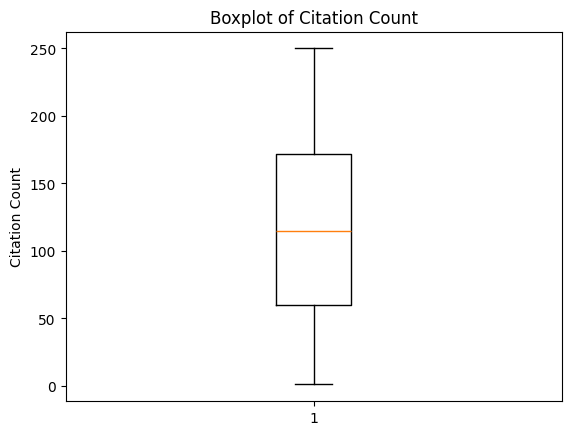

In [28]:
import matplotlib.pyplot as plt

plt.boxplot(accepted_new_paper['citation_count'].dropna())
plt.title('Boxplot of Citation Count')
plt.ylabel('Citation Count')
plt.show()

### check the matadata

In [29]:
print(accepted_new_paper.dtypes)

title                      object
IMPACT                     object
SUBSTANCE                  object
APPROPRIATENESS            object
MEANINGFUL_COMPARISON      object
comments                   object
SOUNDNESS_CORRECTNESS      object
ORIGINALITY                object
RECOMMENDATION             object
CLARITY                    object
REVIEWER_CONFIDENCE        object
citation_count              int64
source                     object
PRESENTATION_FORMAT_NUM     int64
dtype: object


### Make the 'object' to 'numerical'

In [30]:
# make the string to numerical
numerical_columns = ['IMPACT', 'SUBSTANCE', 'APPROPRIATENESS',
       'MEANINGFUL_COMPARISON', 'PRESENTATION_FORMAT_NUM', 
       'SOUNDNESS_CORRECTNESS', 'ORIGINALITY', 'RECOMMENDATION', 'CLARITY',
       'REVIEWER_CONFIDENCE', 'citation_count']
for column in numerical_columns:
    accepted_new_paper[column] = pd.to_numeric(accepted_new_paper[column])


In [31]:
print(accepted_new_paper.dtypes)

title                      object
IMPACT                      int64
SUBSTANCE                   int64
APPROPRIATENESS             int64
MEANINGFUL_COMPARISON       int64
comments                   object
SOUNDNESS_CORRECTNESS       int64
ORIGINALITY                 int64
RECOMMENDATION              int64
CLARITY                     int64
REVIEWER_CONFIDENCE         int64
citation_count              int64
source                     object
PRESENTATION_FORMAT_NUM     int64
dtype: object


In [36]:
accepted_new_paper.describe()

,IMPACT,SUBSTANCE,APPROPRIATENESS,MEANINGFUL_COMPARISON,SOUNDNESS_CORRECTNESS,ORIGINALITY,RECOMMENDATION,CLARITY,REVIEWER_CONFIDENCE,citation_count,PRESENTATION_FORMAT_NUM
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,3.238372,3.668605,4.889535,3.563953,4.063953,3.848837,3.517442,4.034884,3.883721,117.744186,1.505814
std,0.636266,0.787737,0.396632,0.879582,0.872908,0.892037,0.783409,0.871212,0.786116,64.085868,0.501426
min,2.000000,1.000000,2.000000,1.000000,3.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000
25%,3.000000,3.000000,5.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,60.000000,1.000000
50%,3.000000,4.000000,5.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,115.000000,2.000000
75%,3.000000,4.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,171.750000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,250.000000,2.000000


After review, there is no outlier data, thus we have finished the data cleaning.

In [33]:
accepted_new_paper.dtypes

title                      object
IMPACT                      int64
SUBSTANCE                   int64
APPROPRIATENESS             int64
MEANINGFUL_COMPARISON       int64
comments                   object
SOUNDNESS_CORRECTNESS       int64
ORIGINALITY                 int64
RECOMMENDATION              int64
CLARITY                     int64
REVIEWER_CONFIDENCE         int64
citation_count              int64
source                     object
PRESENTATION_FORMAT_NUM     int64
dtype: object

In [34]:
accepted_clean = accepted_new_paper.drop(columns=['comments']) 

In [35]:
accepted_clean.to_pickle('data/accepted_clean.pkl')